# Lung Nodule Detection

In [ ]:
#list of useful imports that  I will use
%matplotlib inline
import os
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob
import seaborn as sns
import random
from keras.preprocessing import image 
import tensorflow as tf



from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [ ]:
data = r'C:\Users\sowmy\Music\project\Data'

In [ ]:
train_data = r"C:\Users\sowmy\Music\project\Data\train"

In [ ]:
Images = []
import os
for dirname, _, filenames in os.walk(data):
    for filename in filenames:
        img = os.path.join(dirname, filename)
        Images.append(img)

In [ ]:
Images[:10]

In [8]:
len(Images)

986

In [9]:
Class_label = []
for i in Images:
  j = i.split("\\")
  #print(j)
  Class_label.append(j[-2])
  #break

In [10]:
Class_label[:10]

['adenocarcinoma',
 'adenocarcinoma',
 'adenocarcinoma',
 'adenocarcinoma',
 'adenocarcinoma',
 'adenocarcinoma',
 'adenocarcinoma',
 'adenocarcinoma',
 'adenocarcinoma',
 'adenocarcinoma']

In [11]:
len(Class_label)

986

In [12]:
# Shuffle two lists with same order 
# Using zip() + * operator + shuffle() 
temp = list(zip(Images, Class_label)) 
random.shuffle(temp) 
Images, Class_label = zip(*temp) 

In [13]:
data = pd.DataFrame(list(zip(Images, Class_label)), columns =['Image_path', 'Class_label'])

In [14]:
data.shape

(986, 2)

In [15]:
data.head(5)

,Image_path,Class_label
0,C:\Users\sowmy\Music\project\Data\train\adenoc...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
1,C:\Users\sowmy\Music\project\Data\train\large....,large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
2,C:\Users\sowmy\Music\project\Data\train\large....,large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
3,C:\Users\sowmy\Music\project\Data\train\large....,large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
4,C:\Users\sowmy\Music\project\Data\train\squamo...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


In [16]:
data.Class_label.value_counts() 

adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib          218
normal                                              201
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa    170
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       136
adenocarcinoma                                      120
squamous.cell.carcinoma                              90
large.cell.carcinoma                                 51
Name: Class_label, dtype: int64

In [17]:
data = data.replace({'Class_label' : { 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib' : 'Adenocarcinoma', 'normal' : 'Normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa' : 'Squamous cell carcinoma','large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa' : 'Large cell carcinoma','adenocarcinoma' :'Adenocarcinoma','squamous.cell.carcinoma' : 'Squamous cell carcinoma' ,'large.cell.carcinoma' : 'Large cell carcinoma'}})

In [18]:
data = data.sample(frac=1)

In [19]:
data.head() 

,Image_path,Class_label
319,C:\Users\sowmy\Music\project\Data\train\adenoc...,Adenocarcinoma
315,C:\Users\sowmy\Music\project\Data\train\adenoc...,Adenocarcinoma
873,C:\Users\sowmy\Music\project\Data\test\adenoca...,Adenocarcinoma
327,C:\Users\sowmy\Music\project\Data\valid\adenoc...,Adenocarcinoma
186,C:\Users\sowmy\Music\project\Data\test\adenoca...,Adenocarcinoma


In [20]:
data.Class_label.value_counts() 

Adenocarcinoma             338
Squamous cell carcinoma    260
Normal                     201
Large cell carcinoma       187
Name: Class_label, dtype: int64

<AxesSubplot:xlabel='Class_label', ylabel='count'>

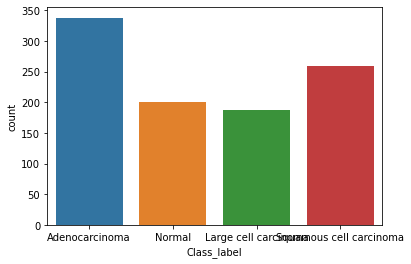

In [21]:
sns.countplot(x = data.Class_label, data = data) 

Text(0.5, 0, 'Class_label')

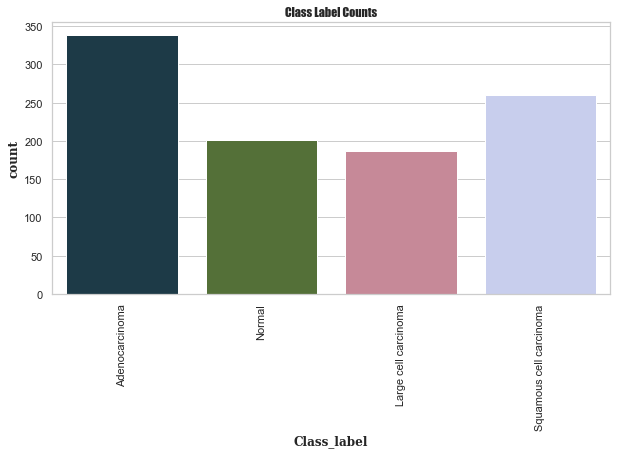

In [22]:
#counts of top 10 drugs
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
ax = sns.countplot(x="Class_label", data=data, palette=sns.color_palette("cubehelix", 4))
plt.xticks(rotation=90)
plt.title("Class Label Counts", {"fontname":"fantasy", "fontweight":"bold", "fontsize":"medium"})
plt.ylabel("count", {"fontname": "serif", "fontweight":"bold"})
plt.xlabel("Class_label", {"fontname": "serif", "fontweight":"bold"}) 

In [23]:
data.Class_label.value_counts()

Adenocarcinoma             338
Squamous cell carcinoma    260
Normal                     201
Large cell carcinoma       187
Name: Class_label, dtype: int64

In [24]:
from sklearn.utils import resample
# Separate majority and minority classes
df_c0 = data[data['Class_label']== 'Adenocarcinoma']
df_c1 = data[data['Class_label']== 'Squamous cell carcinoma']
df_c2 = data[data['Class_label']== 'Normal']
df_c3 = data[data['Class_label']== 'Large cell carcinoma']

 
# Downsample majority class
df_c0_upsampled = resample(df_c0, replace=False,  n_samples = 200,random_state=123)
df_c1_upsampled = resample(df_c1, replace=False,  n_samples = 200,random_state=123)
df_c2_upsampled = resample(df_c2, replace=False,  n_samples = 200,random_state=123)
df_c3_upsampled = resample(df_c3, replace=True,  n_samples = 200,random_state=123)


# Combine minority class with downsampled majority class
df_upsampled = pd.concat([df_c0_upsampled,df_c1_upsampled,df_c2_upsampled,df_c3_upsampled])
 
# Display new class counts
df_upsampled['Class_label'].value_counts()

Adenocarcinoma             200
Squamous cell carcinoma    200
Normal                     200
Large cell carcinoma       200
Name: Class_label, dtype: int64

Text(0.5, 0, 'Class_label')

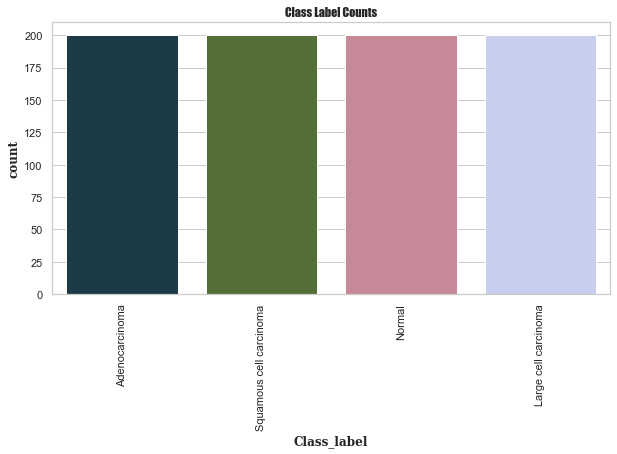

In [25]:
#counts of top 10 drugs
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
ax = sns.countplot(x="Class_label", data=df_upsampled, palette=sns.color_palette("cubehelix", 4))
plt.xticks(rotation=90)
plt.title("Class Label Counts", {"fontname":"fantasy", "fontweight":"bold", "fontsize":"medium"})
plt.ylabel("count", {"fontname": "serif", "fontweight":"bold"})
plt.xlabel("Class_label", {"fontname": "serif", "fontweight":"bold"})

In [26]:
data = df_upsampled.sample(frac=1)

In [27]:
data.head()

,Image_path,Class_label
969,C:\Users\sowmy\Music\project\Data\train\large....,Large cell carcinoma
19,C:\Users\sowmy\Music\project\Data\train\normal...,Normal
920,C:\Users\sowmy\Music\project\Data\test\squamou...,Squamous cell carcinoma
865,C:\Users\sowmy\Music\project\Data\train\squamo...,Squamous cell carcinoma
963,C:\Users\sowmy\Music\project\Data\train\squamo...,Squamous cell carcinoma


## Resize the images

In [28]:
def resize_images(img):
  file = Image.open(img)
  img = file.convert('RGB')
  img_bgr= img.resize((224, 224))
  img_bgr = np.array(img_bgr)
  return img_bgr

In [29]:
from PIL import Image

In [30]:
#save resized images into images.
images = [resize_images(img) for img in data['Image_path']]

In [31]:
# print number of classes in our dataset 
num_classes = len(np.unique(data['Class_label']))

In [32]:
num_classes

4

In [33]:
# save the class into class_names
class_names = list(data['Class_label'])

In [34]:
# Print the shape of the image
images[0].shape

(224, 224, 3)

Text(0.5, 1.0, 'Normal')

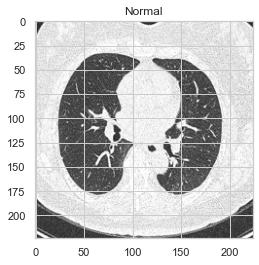

In [35]:
#See the image with class label
plt.imshow(images[5])
plt.title(class_names[5])

Text(0.5, 1.0, 'Adenocarcinoma')

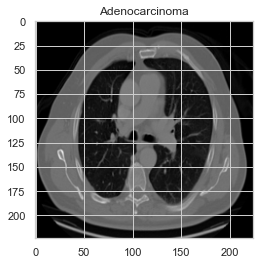

In [36]:
#See the image with class label
plt.imshow(images[10])
plt.title(class_names[10])

Text(0.5, 1.0, 'Normal')

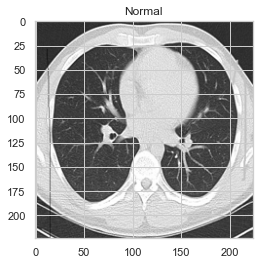

In [37]:
#See the image with class label
plt.imshow(images[400])
plt.title(class_names[400])

Text(0.5, 1.0, 'Large cell carcinoma')

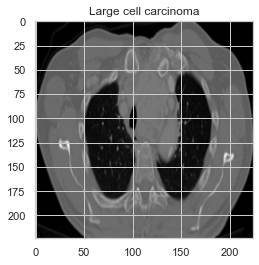

In [38]:
#See the image with class label
plt.imshow(images[70])
plt.title(class_names[70])

In [39]:
# Convert the images into array
images =  np.array(images)

In [40]:
# Shape of the images
images.shape

(800, 224, 224, 3)

In [41]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(data['Class_label'])

In [42]:
data['Class_label'][:10]

969       Large cell carcinoma
19                      Normal
920    Squamous cell carcinoma
865    Squamous cell carcinoma
963    Squamous cell carcinoma
33                      Normal
167                     Normal
803                     Normal
452                     Normal
725                     Normal
Name: Class_label, dtype: object

## Spliting data into training and testing

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3,stratify = y,random_state=42)

In [44]:
X_train.shape

(560, 224, 224, 3)

In [45]:
X_test.shape

(240, 224, 224, 3)

# CNN Model

In [46]:
# Set the CNN model 

batch_size = None

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', batch_input_shape = (batch_size,224, 224, 3)))


model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))



model.add(GlobalMaxPooling2D())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                        

In [47]:
# Compile the model
opt = Adam(lr=0.001)

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

D:\Softwares\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
D:\Softwares\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [48]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Fit the model
history = model.fit(X_train, y_train, epochs = 3, validation_data = (X_test,y_test),batch_size = 128)

Epoch 1/3


In [ ]:
# plot the accuracy plot
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'b')
plt.legend({'Train Accuracy': 'r', 'Test Accuracy':'b'})
plt.show()

In [ ]:
# plot the accuracy plot
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

In [ ]:
import tensorflow as tf

In [ ]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
class_names = enc.classes_
df_heatmap = pd.DataFrame(confusion_matrix(np.argmax((model.predict(X_test)),axis = 1),np.argmax(y_test,axis=1)),columns = class_names, index = class_names)
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [ ]:
#print the test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

In [ ]:
# Creating results data frame 
results = pd.DataFrame(columns=['model', 'Test-Accuracy' ])
new = ['CNN ',0.5333]
results.loc[0] = new

# VGG_16 Model

In [ ]:
# import the vgg16 model
from keras.applications.vgg16 import VGG16


In [ ]:
vgg=VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))

In [ ]:
vgg.trainable=False

In [ ]:
# Set the vgg16 model

model_1=Sequential()
model_1.add(vgg)
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(4, activation='softmax'))

In [ ]:
#Compile the model
opt = Adam(lr=0.001)

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_1.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model_1, to_file='model_plot.png', show_shapes=False, show_layer_names=True)

In [ ]:
#Fit the data or train the model
History_1 = model_1.fit(X_train, y_train, epochs = 2, validation_data = (X_test,y_test),batch_size = 128)

In [ ]:
# print the test accuracy
score_2 = model_1.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score_2[1])

In [ ]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
class_names = enc.classes_
df_heatmap = pd.DataFrame(confusion_matrix(np.argmax((model_1.predict(X_test)),axis = 1),np.argmax(y_test,axis=1)),columns = class_names, index = class_names)
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [ ]:
new = ['VGG-16 ',0.9416]
results.loc[1] = new

In [ ]:
# plot the accuracy plot
plt.plot(History_1.history['loss'], 'r')
plt.plot(History_1.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

## Performance Table

In [ ]:
results